In [25]:
# 필요한 library import
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
train_data_path = join('~/aiffel/kaggle_kakr_housing/data', 'train.csv')
sub_data_path = join('~/aiffel/kaggle_kakr_housing/data/', 'test.csv')

### 데이터 살펴보기

In [27]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [28]:
#price 컬럼은 따로 y라는 변수에 저장한 후 해당 컬럼은 지워주기
y = data['price']

del data['price']

In [29]:
#전체 데이터 보기(pd.concat)
train_len = len(data)
data = pd.concat((data, sub), axis=0)

In [30]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 전처리

<AxesSubplot:>

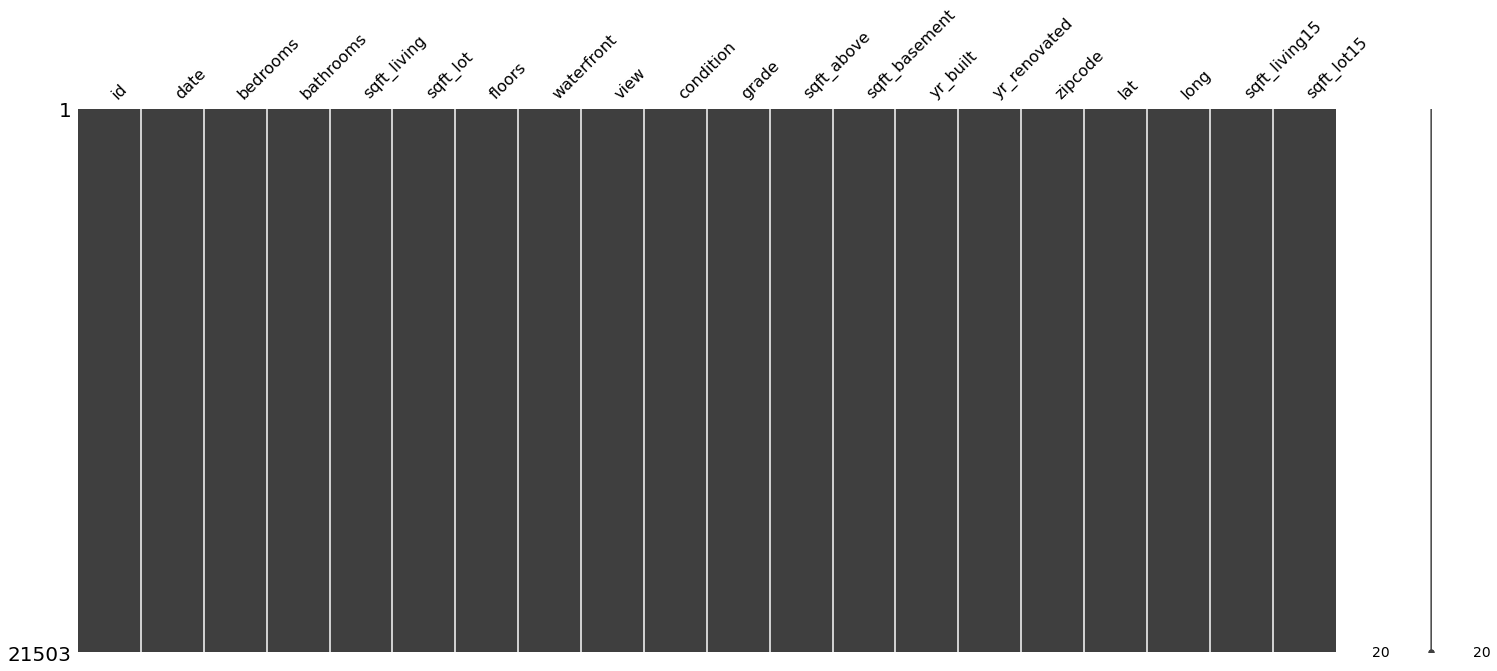

In [31]:
#결측치 확인(missingno 라이브러리의 matrix 함수)
msno.matrix(data)

In [32]:
#한번 더 확인!
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


In [33]:
#id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거
#date 변수는 연월만 고려하는 범주형 변수로 만들기(20141013T000000 -> 201410)
sub_id = data['id'][train_len:] 
del data['id']
data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(str)

In [12]:
#log-scaling(한쪽으로 몰려있는 분포를 넓게 펴주기)
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

In [14]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

### Average Blending(Ensemble)

In [15]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

In [18]:
#교차검증(cross validation)을 통해 모델 성능 평가
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2019, shuffle = True).get_n_splits(x.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x.values, y)), 
                                             kf=kfold))

In [19]:
#회귀 모델의 경우에는 cross_val_score 함수가 R2를 반환, R2값이 1에 가까울수록 학습 데이터에 대한 성능이 좋은 것
get_cv_score(models)

Model GradientBoosting CV score : 0.8597
Model XGBoost CV score : 0.8861
Model LightGBM CV score : 0.8819


In [35]:
#훈련 데이터셋으로 3개 모델 학습
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [21]:
y_pred = AveragingBlending(models, x, y, sub)

In [22]:
sub = pd.DataFrame(data={'id':sub_id,'price':y_pred})

In [23]:
sub.to_csv('submission_2.csv', index=False)

In [ ]:
#private score : 116127